<a href="https://colab.research.google.com/github/Karishma-Kuria/DL-Assignment4/blob/main/DL_Assignment4_Part2a.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **b) Various experiments with weights and biases of hyperparameters in weights and biases of various optimizers, layer depth width, learning rate etc using Pytorch**

Ref: https://colab.research.google.com/github/wandb/examples/blob/master/colabs/pytorch/Organizing_Hyperparameter_Sweeps_in_PyTorch_with_W%26B.ipynb

https://colab.research.google.com/github/wandb/examples/blob/master/colabs/pytorch/Simple_PyTorch_Integration.ipynb

### **Introduction to Hyperparameter Sweeps using W&B**

Using Hyperparameter sweeps provides a better way to pick the most accurate model.  This is done by seraching through the various combination of Hyperparameter values which results in getting the best optimal values.

In this colab we will use Weights and Biases to run sophisticated hyperparameter sweeps in 3 easy steps.

**Sweeps: An Overview**

Running a hyperparameter sweep with Weights & Biases is very easy. There are just 3 simple steps:

**Define the sweep**: we do this by creating a dictionary or a YAML file that specifies the parameters to search through, the search strategy, the optimization metric et all.

**Initialize the sweep**: with one line of code we initialize the sweep and pass in the dictionary of sweep configurations: sweep_id = wandb.sweep(sweep_config)

**Run the sweep agent**: also accomplished with one line of code, we call wandb.agent() and pass the sweep_id to run, along with a function that defines your model architecture and trains it: wandb.agent(sweep_id, function=train)

### **Setup**

In [1]:
# install
!pip install wandb --upgrade

# workaround to fetch MNIST data
!wget www.di.ens.fr/~lelarge/MNIST.tar.gz
!tar -zxvf MNIST.tar.gz

     |████████████████████████████████| 1.8 MB 5.1 MB/s 
     |████████████████████████████████| 144 kB 34.7 MB/s 
     |████████████████████████████████| 181 kB 12.3 MB/s 
     |████████████████████████████████| 63 kB 1.1 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=cd379277e1dda799be7efb61739518be1b081493b2b22c07f517018f853249aa
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools
--2022-04-14 10:47:16--  http://www.di.ens.fr/~lelarge/MNIST.tar.gz
Resolving www.di.ens.fr (www.di.ens.fr)... 129.199.99.14
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.di.ens.fr/~lelarge/MNIST.tar.gz [following]
--2022-04-14 10:47:16--  https://www.di.ens.fr/~lelarge/MNIST.tar.gz
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:443... connected.
HTTP request sent

In [2]:
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

## **Step 1️⃣. Define the Sweep**

### **Pick a method**

The first thing to do is pick method for searching Hyperparameters.

**3 search methods provided are:**
1. **grid Search** – Iterate over every combination of hyperparameter values. Very effective, but can be computationally costly.
2. **random Search** – Select each new combination at random according to provided distributions. Surprisingly effective!
3. **bayesian Search** – Create a probabilistic model of metric score as a function of the hyperparameters, and choose parameters with high probability of improving the metric. Works well for small numbers of continuous parameters but scales poorly.


Here I have used random search.

In [3]:
sweep_config = {
    'method': 'random'
    }

In [4]:
metric = {
    'name': 'loss',
    'goal': 'minimize'   
    }

sweep_config['metric'] = metric

### **Name the hyperparameters**

Once we are done with the method selection then its time to choose the parameters to search for.
Provide the name of the parameter and its legal values. For instance zi have used optimizer here and provided its values.

In [6]:
parameters_dict = {
    'optimizer': {
        'values': ['adam', 'sgd']
        },
    'fc_layer_size': {
        'values': [128, 256, 512]
        },
    'dropout': {
          'values': [0.3, 0.4, 0.5]
        },
    }

sweep_config['parameters'] = parameters_dict

In [7]:
parameters_dict.update({
    'epochs': {
        'value': 1}
    })

This is all is required for a grid search.

In case of random search, on a given run all the values of a parameter are equally probable to be chosen.

We can also provide distribution if the above doesn't happen along with the values such as mean ***mu*** or standard deviation ***sigma*** etc.

In [8]:
import math

parameters_dict.update({
    'learning_rate': {
        # a flat distribution between 0 and 0.1
        'distribution': 'uniform',
        'min': 0,
        'max': 0.1
      },
    'batch_size': {
        # integers between 32 and 256
        # with evenly-distributed logarithms 
        'distribution': 'q_log_uniform',
        'q': 1,
        'min': math.log(32),
        'max': math.log(256),
      }
    })

Now we are done with the sweep and selected the method and the parameters.

In [9]:
import pprint
pprint.pprint(sweep_config)

{'method': 'random',
 'metric': {'goal': 'minimize', 'name': 'loss'},
 'parameters': {'batch_size': {'distribution': 'q_log_uniform',
                               'max': 5.545177444479562,
                               'min': 3.4657359027997265,
                               'q': 1},
                'dropout': {'values': [0.3, 0.4, 0.5]},
                'epochs': {'value': 1},
                'fc_layer_size': {'values': [128, 256, 512]},
                'learning_rate': {'distribution': 'uniform',
                                  'max': 0.1,
                                  'min': 0},
                'optimizer': {'values': ['adam', 'sgd']}}}


## **Step 2️⃣. Initialize the Sweep**

Now we will call  wandb.sweep with the appropriate sweep_config and project name to wind up a Sweep Controller.

This above function will returns a sweep_id.
Thisid will be used later to assign agents to this Controller.

In [10]:
sweep_id = wandb.sweep(sweep_config, project="pytorch-sweeps-demo")

wandb: WARNING Malformed sweep config detected! This may cause your sweep to behave in unexpected ways.
wandb: WARNING To avoid this, please fix the sweep config schema violations below:
wandb: WARNING   Violation 1. batch_size uses q_log_uniform, where min/max specify base-e exponents. Use q_log_uniform_values to specify limit values.


Create sweep with ID: syjxvfdr
Sweep URL: https://wandb.ai/karishma/pytorch-sweeps-demo/sweeps/syjxvfdr


## **Step 3️⃣. Run the Sweep agent**

### **Defining Training Procedure**

Before we can actually execute the sweep, we need to define the training procedure that uses those values.

In the functions below, we define a simple fully-connected neural network in PyTorch, and add the following wandb tools to log model metrics, visualize performance and output and track our experiments:

**wandb.init()** – Initialize a new W&B Run. Each Run is a single execution of the training function.

**wandb.config** – Save all your hyperparameters in a configuration object so they can be logged. Read more about how to use wandb.config here.

**wandb.log()** – log model behavior to W&B. Here, we just log the performance; see this Colab for all the other rich media that can be logged with wandb.log.
For more details on instrumenting W&B with PyTorch, see this Colab.

In [11]:
import torch
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
from torchvision import datasets, transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train(config=None):
    # Initialize a new wandb run
    with wandb.init(config=config):
        # If called by wandb.agent, as below,
        # this config will be set by Sweep Controller
        config = wandb.config

        loader = build_dataset(config.batch_size)
        network = build_network(config.fc_layer_size, config.dropout)
        optimizer = build_optimizer(network, config.optimizer, config.learning_rate)

        for epoch in range(config.epochs):
            avg_loss = train_epoch(network, loader, optimizer)
            wandb.log({"loss": avg_loss, "epoch": epoch})           

This cell defines the four pieces of our training procedure:
`build_dataset`, `build_network`, `build_optimizer`, and `train_epoch`.

All of these are a standard part of a basic PyTorch pipeline,
and their implementation is unaffected by the use of W&B,
so we won't comment on them.

In [12]:
def build_dataset(batch_size):
   
    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.1307,), (0.3081,))])
    # download MNIST training dataset
    dataset = datasets.MNIST(".", train=True, download=True,
                             transform=transform)
    sub_dataset = torch.utils.data.Subset(
        dataset, indices=range(0, len(dataset), 5))
    loader = torch.utils.data.DataLoader(sub_dataset, batch_size=batch_size)

    return loader


def build_network(fc_layer_size, dropout):
    network = nn.Sequential(  # fully-connected, single hidden layer
        nn.Flatten(),
        nn.Linear(784, fc_layer_size), nn.ReLU(),
        nn.Dropout(dropout),
        nn.Linear(fc_layer_size, 10),
        nn.LogSoftmax(dim=1))

    return network.to(device)
        

def build_optimizer(network, optimizer, learning_rate):
    if optimizer == "sgd":
        optimizer = optim.SGD(network.parameters(),
                              lr=learning_rate, momentum=0.9)
    elif optimizer == "adam":
        optimizer = optim.Adam(network.parameters(),
                               lr=learning_rate)
    return optimizer


def train_epoch(network, loader, optimizer):
    cumu_loss = 0
    for _, (data, target) in enumerate(loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()

        # ➡ Forward pass
        loss = F.nll_loss(network(data), target)
        cumu_loss += loss.item()

        # ⬅ Backward pass + weight update
        loss.backward()
        optimizer.step()

        wandb.log({"batch loss": loss.item()})

    return cumu_loss / len(loader)

The cell below will launch an `agent` that runs `train` 5 times,
usingly the randomly-generated hyperparameter values returned by the Sweep Controller. Execution takes under 5 minutes.

In [13]:
wandb.agent(sweep_id, train, count=5)

wandb: Agent Starting Run: 2r6k4e33 with config:
wandb: 	batch_size: 183
wandb: 	dropout: 0.4
wandb: 	epochs: 1
wandb: 	fc_layer_size: 128
wandb: 	learning_rate: 0.007227730940592193
wandb: 	optimizer: adam
wandb: Currently logged in as: karishma (use `wandb login --relogin` to force relogin)


batch loss,█▇▅▄▃▃▂▂▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▂▁▁▂▁▁▁▁▁
epoch,▁
loss,▁
batch loss,0.35002
epoch,0
loss,0.5761


wandb: Agent Starting Run: ishcgl51 with config:
wandb: 	batch_size: 94
wandb: 	dropout: 0.3
wandb: 	epochs: 1
wandb: 	fc_layer_size: 256
wandb: 	learning_rate: 0.06983411730184674
wandb: 	optimizer: adam


batch loss,▇█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁
loss,▁
batch loss,1.66329
epoch,0
loss,4.81387


wandb: Agent Starting Run: gvmo9it7 with config:
wandb: 	batch_size: 182
wandb: 	dropout: 0.3
wandb: 	epochs: 1
wandb: 	fc_layer_size: 512
wandb: 	learning_rate: 0.08052561815480888
wandb: 	optimizer: adam


batch loss,▁▇▇█▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁
loss,▁
batch loss,1.80001
epoch,0
loss,20.79792


wandb: Agent Starting Run: umpmomnt with config:
wandb: 	batch_size: 213
wandb: 	dropout: 0.5
wandb: 	epochs: 1
wandb: 	fc_layer_size: 128
wandb: 	learning_rate: 0.09930397650297249
wandb: 	optimizer: sgd


batch loss,██▇▅▄▃▃▂▂▃▂▃▂▂▂▂▂▂▂▂▂▁▂▁▁▂▁▁▁▁▁▂▁▁▂▁▁▁▁▁
epoch,▁
loss,▁
batch loss,0.41182
epoch,0
loss,0.72737


wandb: Agent Starting Run: h9ot7vnw with config:
wandb: 	batch_size: 34
wandb: 	dropout: 0.5
wandb: 	epochs: 1
wandb: 	fc_layer_size: 512
wandb: 	learning_rate: 0.09861337725854274
wandb: 	optimizer: sgd


batch loss,▄▄▄▇▂▆▃▂▂▅▁▆▄▃▅▂▃▅▃▃▃▃▄▄▄▄▄▄▃▃▃█▅▃▄▄▄▃▃▃
epoch,▁
loss,▁
batch loss,1.69586
epoch,0
loss,2.04627


### **Visualize Sweep Results**
check the result here:
https://wandb.ai/karishma/pytorch-sweeps-demo/runs/h9ot7vnw?workspace=user-karishma




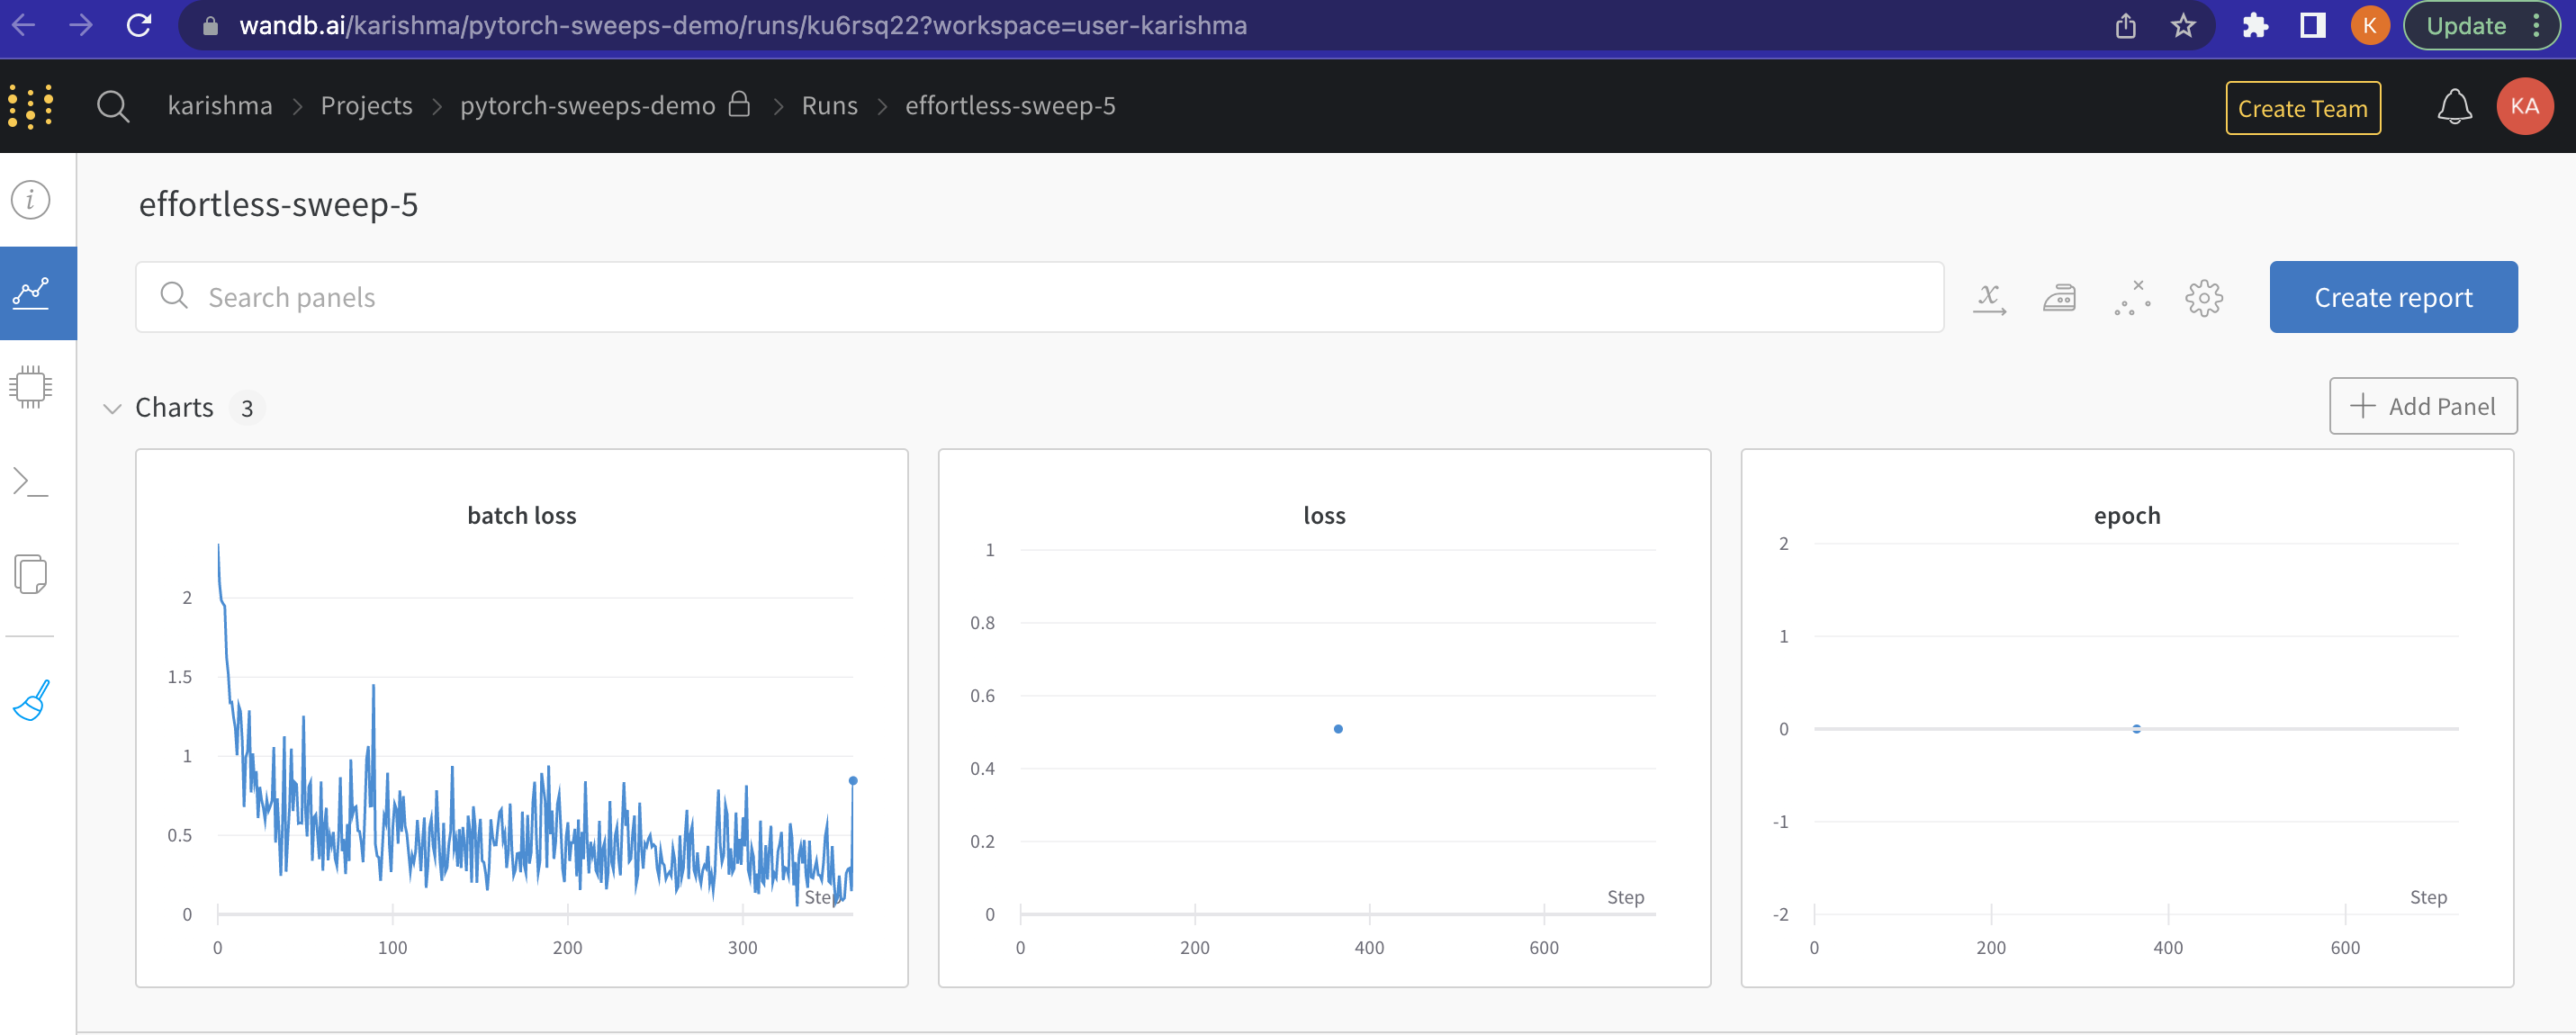


## **Introducing Weights & Bias to PyTorch**

I will show you how to integrate Weights & Biases with your PyTorch code to add experiment tracking to your pipeline.

### 🚀 Install, Import, and Log In

In [16]:
import os
import random

import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from tqdm.notebook import tqdm

# Ensure deterministic behavior
torch.backends.cudnn.deterministic = True
random.seed(hash("setting random seeds") % 2**32 - 1)
np.random.seed(hash("improves reproducibility") % 2**32 - 1)
torch.manual_seed(hash("by removing stochasticity") % 2**32 - 1)
torch.cuda.manual_seed_all(hash("so runs are repeatable") % 2**32 - 1)

# Device configuration
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# remove slow mirror from list of MNIST mirrors
torchvision.datasets.MNIST.mirrors = [mirror for mirror in torchvision.datasets.MNIST.mirrors
                                      if not mirror.startswith("http://yann.lecun.com")]

### 0️⃣ Step 0: Install W&B

To get started, we'll need to get the library.
`wandb` is easily installed using `pip`.

In [17]:
%%capture
!pip install wandb --upgrade

### 1️⃣ Step 1: Import W&B and Login

In order to log data to our web service,
you'll need to log in.

If this is your first time using W&B,
you'll need to sign up for a free account at the link that appears.

In [18]:
import wandb

wandb.login()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

### 👩‍🔬 Define the Experiment and Pipeline

### 2️⃣ Step 2: Track metadata and hyperparameters with `wandb.init`

Programmatically, the first thing we do is define our experiment:
what are the hyperparameters? what metadata is associated with this run?

It's a pretty common workflow to store this information in a `config` dictionary
(or similar object)
and then access it as needed.

For this example, we're only letting a few hyperparameters vary
and hand-coding the rest.
But any part of your model can be part of the `config`!

We also include some metadata: we're using the MNIST dataset and a convolutional
architecture. If we later work with, say,
fully-connected architectures on CIFAR in the same project,
this will help us separate our runs.

In [19]:
config = dict(
    epochs=5,
    classes=10,
    kernels=[16, 32],
    batch_size=128,
    learning_rate=0.005,
    dataset="MNIST",
    architecture="CNN")

Now, let's define the overall pipeline,
which is pretty typical for model-training:

1. we first `make` a model, plus associated data and optimizer, then
2. we `train` the model accordingly and finally
3. `test` it to see how training went.

We'll implement these functions below.

In [20]:
def model_pipeline(hyperparameters):

    # tell wandb to get started
    with wandb.init(project="pytorch-demo", config=hyperparameters):
      # access all HPs through wandb.config, so logging matches execution!
      config = wandb.config

      # make the model, data, and optimization problem
      model, train_loader, test_loader, criterion, optimizer = make(config)
      print(model)

      # and use them to train the model
      train(model, train_loader, criterion, optimizer, config)

      # and test its final performance
      test(model, test_loader)

    return model

The only difference here from a standard pipeline
is that it all occurs inside the context of `wandb.init`.
Calling this function sets up a line of communication
between your code and our servers.

Passing the `config` dictionary to `wandb.init`
immediately logs all that information to us,
so you'll always know what hyperparameter values
you set your experiment to use.

To ensure the values you chose and logged are always the ones that get used
in your model, we recommend using the `wandb.config` copy of your object.
Check the definition of `make` below to see some examples.

> *Side Note*: We take care to run our code in separate processes,
so that any issues on our end
(e.g. a giant sea monster attacks our data centers)
don't crash your code.
Once the issue is resolved (e.g. the Kraken returns to the deep)
you can log the data with `wandb sync`.

In [21]:
def make(config):
    # Make the data
    train, test = get_data(train=True), get_data(train=False)
    train_loader = make_loader(train, batch_size=config.batch_size)
    test_loader = make_loader(test, batch_size=config.batch_size)

    # Make the model
    model = ConvNet(config.kernels, config.classes).to(device)

    # Make the loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(
        model.parameters(), lr=config.learning_rate)
    
    return model, train_loader, test_loader, criterion, optimizer

### 📡 Define the Data Loading and Model

Now, we need to specify how the data is loaded and what the model looks like.

This part is very important, but it's
no different from what it would be without `wandb`,
so we won't dwell on it.

In [22]:
def get_data(slice=5, train=True):
    full_dataset = torchvision.datasets.MNIST(root=".",
                                              train=train, 
                                              transform=transforms.ToTensor(),
                                              download=True)
    #  equiv to slicing with [::slice] 
    sub_dataset = torch.utils.data.Subset(
      full_dataset, indices=range(0, len(full_dataset), slice))
    
    return sub_dataset


def make_loader(dataset, batch_size):
    loader = torch.utils.data.DataLoader(dataset=dataset,
                                         batch_size=batch_size, 
                                         shuffle=True,
                                         pin_memory=True, num_workers=2)
    return loader

Defining the model is normally the fun part!

But nothing changes with `wandb`,
so we're gonna stick with a standard ConvNet architecture.

Don't be afraid to mess around with this and try some experiments --
all your results will be logged on [wandb.ai](https://wandb.ai)!



In [23]:
# Conventional and convolutional neural network

class ConvNet(nn.Module):
    def __init__(self, kernels, classes=10):
        super(ConvNet, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, kernels[0], kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, kernels[1], kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = nn.Linear(7 * 7 * kernels[-1], classes)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out

### 👟 Define Training Logic

Moving on in our `model_pipeline`, it's time to specify how we `train`.

Two `wandb` functions come into play here: `watch` and `log`.

### 3️⃣ Step 3. Track gradients with `wandb.watch` and everything else with `wandb.log`

`wandb.watch` will log the gradients and the parameters of your model,
every `log_freq` steps of training.

All you need to do is call it before you start training.

The rest of the training code remains the same:
we iterate over epochs and batches,
running forward and backward passes
and applying our `optimizer`.

In [24]:
def train(model, loader, criterion, optimizer, config):
    # Tell wandb to watch what the model gets up to: gradients, weights, and more!
    wandb.watch(model, criterion, log="all", log_freq=10)

    # Run training and track with wandb
    total_batches = len(loader) * config.epochs
    example_ct = 0  # number of examples seen
    batch_ct = 0
    for epoch in tqdm(range(config.epochs)):
        for _, (images, labels) in enumerate(loader):

            loss = train_batch(images, labels, model, optimizer, criterion)
            example_ct +=  len(images)
            batch_ct += 1

            # Report metrics every 25th batch
            if ((batch_ct + 1) % 25) == 0:
                train_log(loss, example_ct, epoch)


def train_batch(images, labels, model, optimizer, criterion):
    images, labels = images.to(device), labels.to(device)
    
    # Forward pass ➡
    outputs = model(images)
    loss = criterion(outputs, labels)
    
    # Backward pass ⬅
    optimizer.zero_grad()
    loss.backward()

    # Step with optimizer
    optimizer.step()

    return loss

The only difference is in the logging code:
where previously you might have reported metrics by printing to the terminal,
now you pass the same information to `wandb.log`.

`wandb.log` expects a dictionary with strings as keys.
These strings identify the objects being logged, which make up the values.
You can also optionally log which `step` of training you're on.

> *Side Note*: I like to use the number of examples the model has seen,
since this makes for easier comparison across batch sizes,
but you can use raw steps or batch count. For longer training runs, it can also make sense to log by `epoch`.

In [25]:
def train_log(loss, example_ct, epoch):
    # Where the magic happens
    wandb.log({"epoch": epoch, "loss": loss}, step=example_ct)
    print(f"Loss after " + str(example_ct).zfill(5) + f" examples: {loss:.3f}")

### 🧪 Define Testing Logic

Once the model is done training, we want to test it:
run it against some fresh data from production, perhaps,
or apply it to some hand-curated "hard examples".



#### 4️⃣ Optional Step 4: Call `wandb.save`

This is also a great time to save the model's architecture
and final parameters to disk.
For maximum compatibility, we'll `export` our model in the
[Open Neural Network eXchange (ONNX) format](https://onnx.ai/).

Passing that filename to `wandb.save` ensures that the model parameters
are saved to W&B's servers: no more losing track of which `.h5` or `.pb`
corresponds to which training runs!

For more advanced `wandb` features for storing, versioning, and distributing
models, check out our [Artifacts tools](https://www.wandb.com/artifacts).

In [26]:
def test(model, test_loader):
    model.eval()

    # Run the model on some test examples
    with torch.no_grad():
        correct, total = 0, 0
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        print(f"Accuracy of the model on the {total} " +
              f"test images: {100 * correct / total}%")
        
        wandb.log({"test_accuracy": correct / total})

    # Save the model in the exchangeable ONNX format
    torch.onnx.export(model, images, "model.onnx")
    wandb.save("model.onnx")

### 🏃‍♀️ Run training and watch your metrics live on wandb.ai!

Now that we've defined the whole pipeline and slipped in
those few lines of W&B code,
we're ready to run our fully-tracked experiment.

We'll report a few links to you:
our documentation,
the Project page, which organizes all the runs in a project, and
the Run page, where this run's results will be stored.

Navigate to the Run page and check out these tabs:

1. **Charts**, where the model gradients, parameter values, and loss are logged throughout training
2. **System**, which contains a variety of system metrics, including Disk I/O utilization, CPU and GPU metrics (watch that temperature soar 🔥), and more
3. **Logs**, which has a copy of anything pushed to standard out during training
4. **Files**, where, once training is complete, you can click on the `model.onnx` to view our network with the [Netron model viewer](https://github.com/lutzroeder/netron).

Once the run in finished
(i.e. the `with wandb.init` block is exited),
we'll also print a summary of the results in the cell output.

In [27]:
# Build, train and analyze the model with the pipeline
model = model_pipeline(config)

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


ConvNet(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=1568, out_features=10, bias=True)
)


  0%|          | 0/1 [00:00<?, ?it/s]

Loss after 00816 examples: 2.307
Loss after 01666 examples: 2.277
Loss after 02516 examples: 2.300
Loss after 03366 examples: 2.320
Loss after 04216 examples: 2.296
Loss after 05066 examples: 2.305
Loss after 05916 examples: 2.306
Loss after 06766 examples: 2.284
Loss after 07616 examples: 2.281
Loss after 08466 examples: 2.285
Loss after 09316 examples: 2.319
Loss after 10166 examples: 2.306
Loss after 11016 examples: 2.304
Loss after 11866 examples: 2.300
Accuracy of the model on the 2000 test images: 9.35%



epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,▆▁▅█▄▆▆▂▂▂█▆▅▅
test_accuracy,▁
epoch,0
loss,2.29969
test_accuracy,0.0935


### **Visualize Sweep Results**
check the result here:
https://wandb.ai/karishma/pytorch-sweeps-demo/runs/h9ot7vnw?workspace=user-karishma


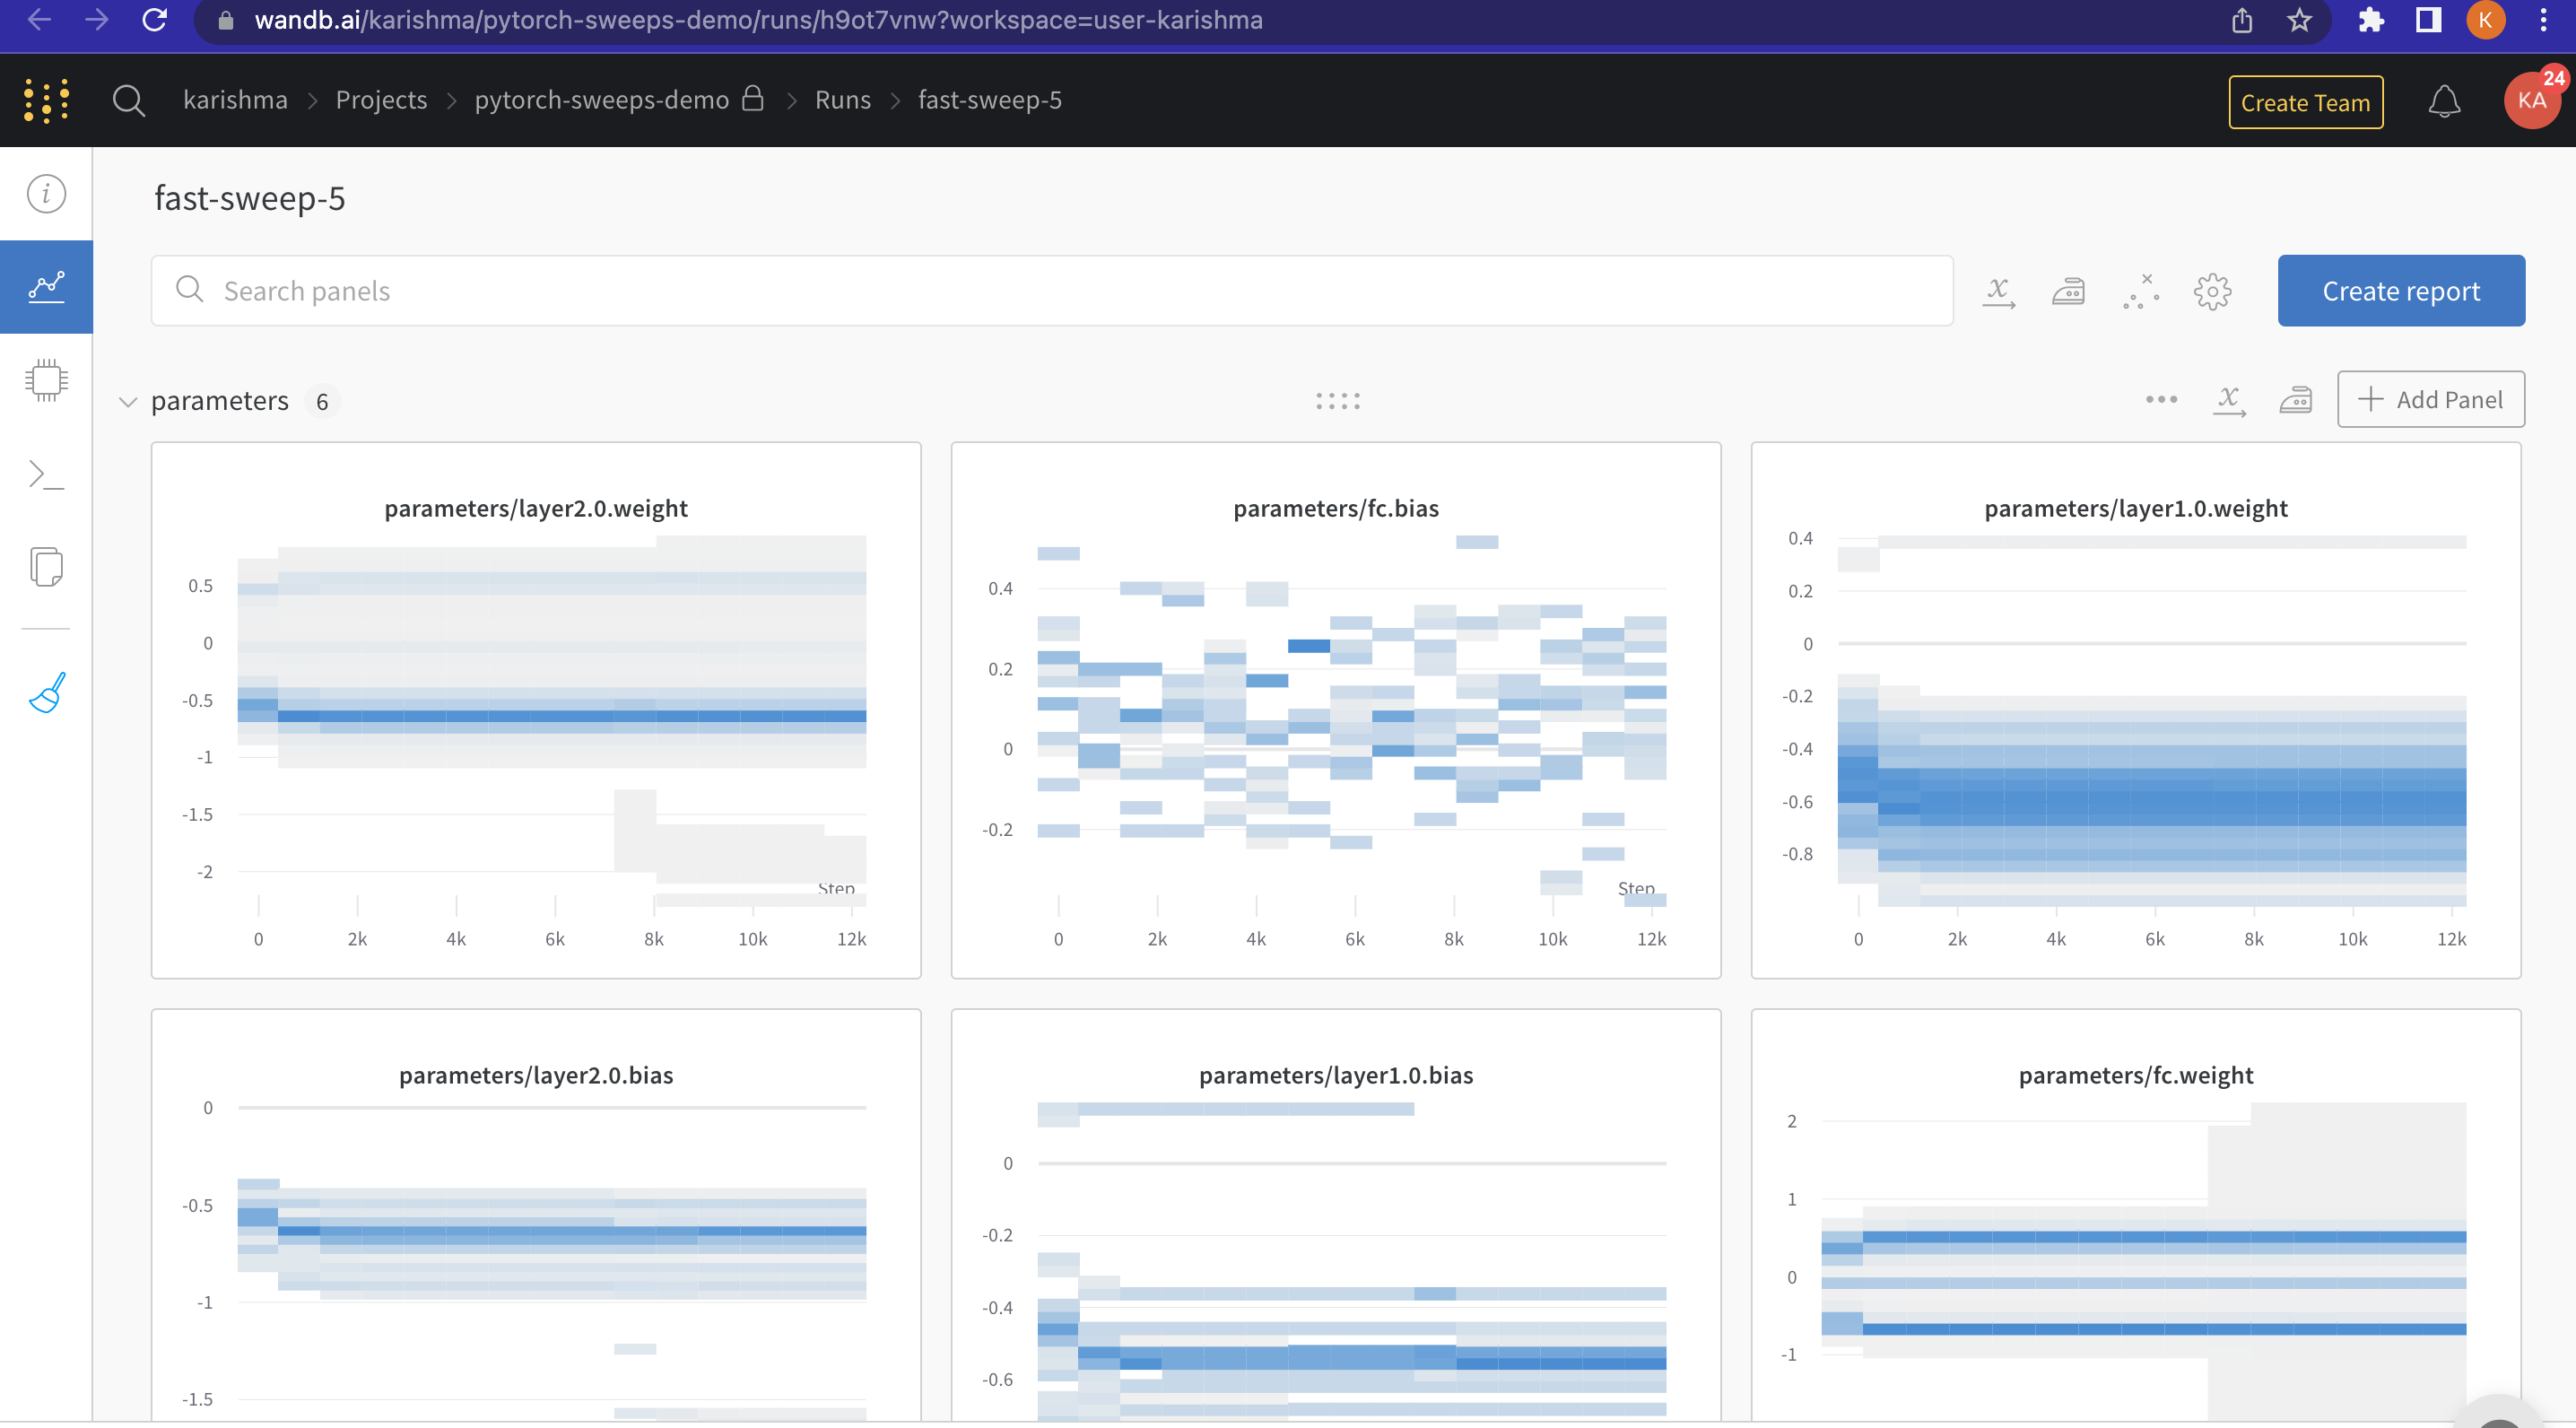

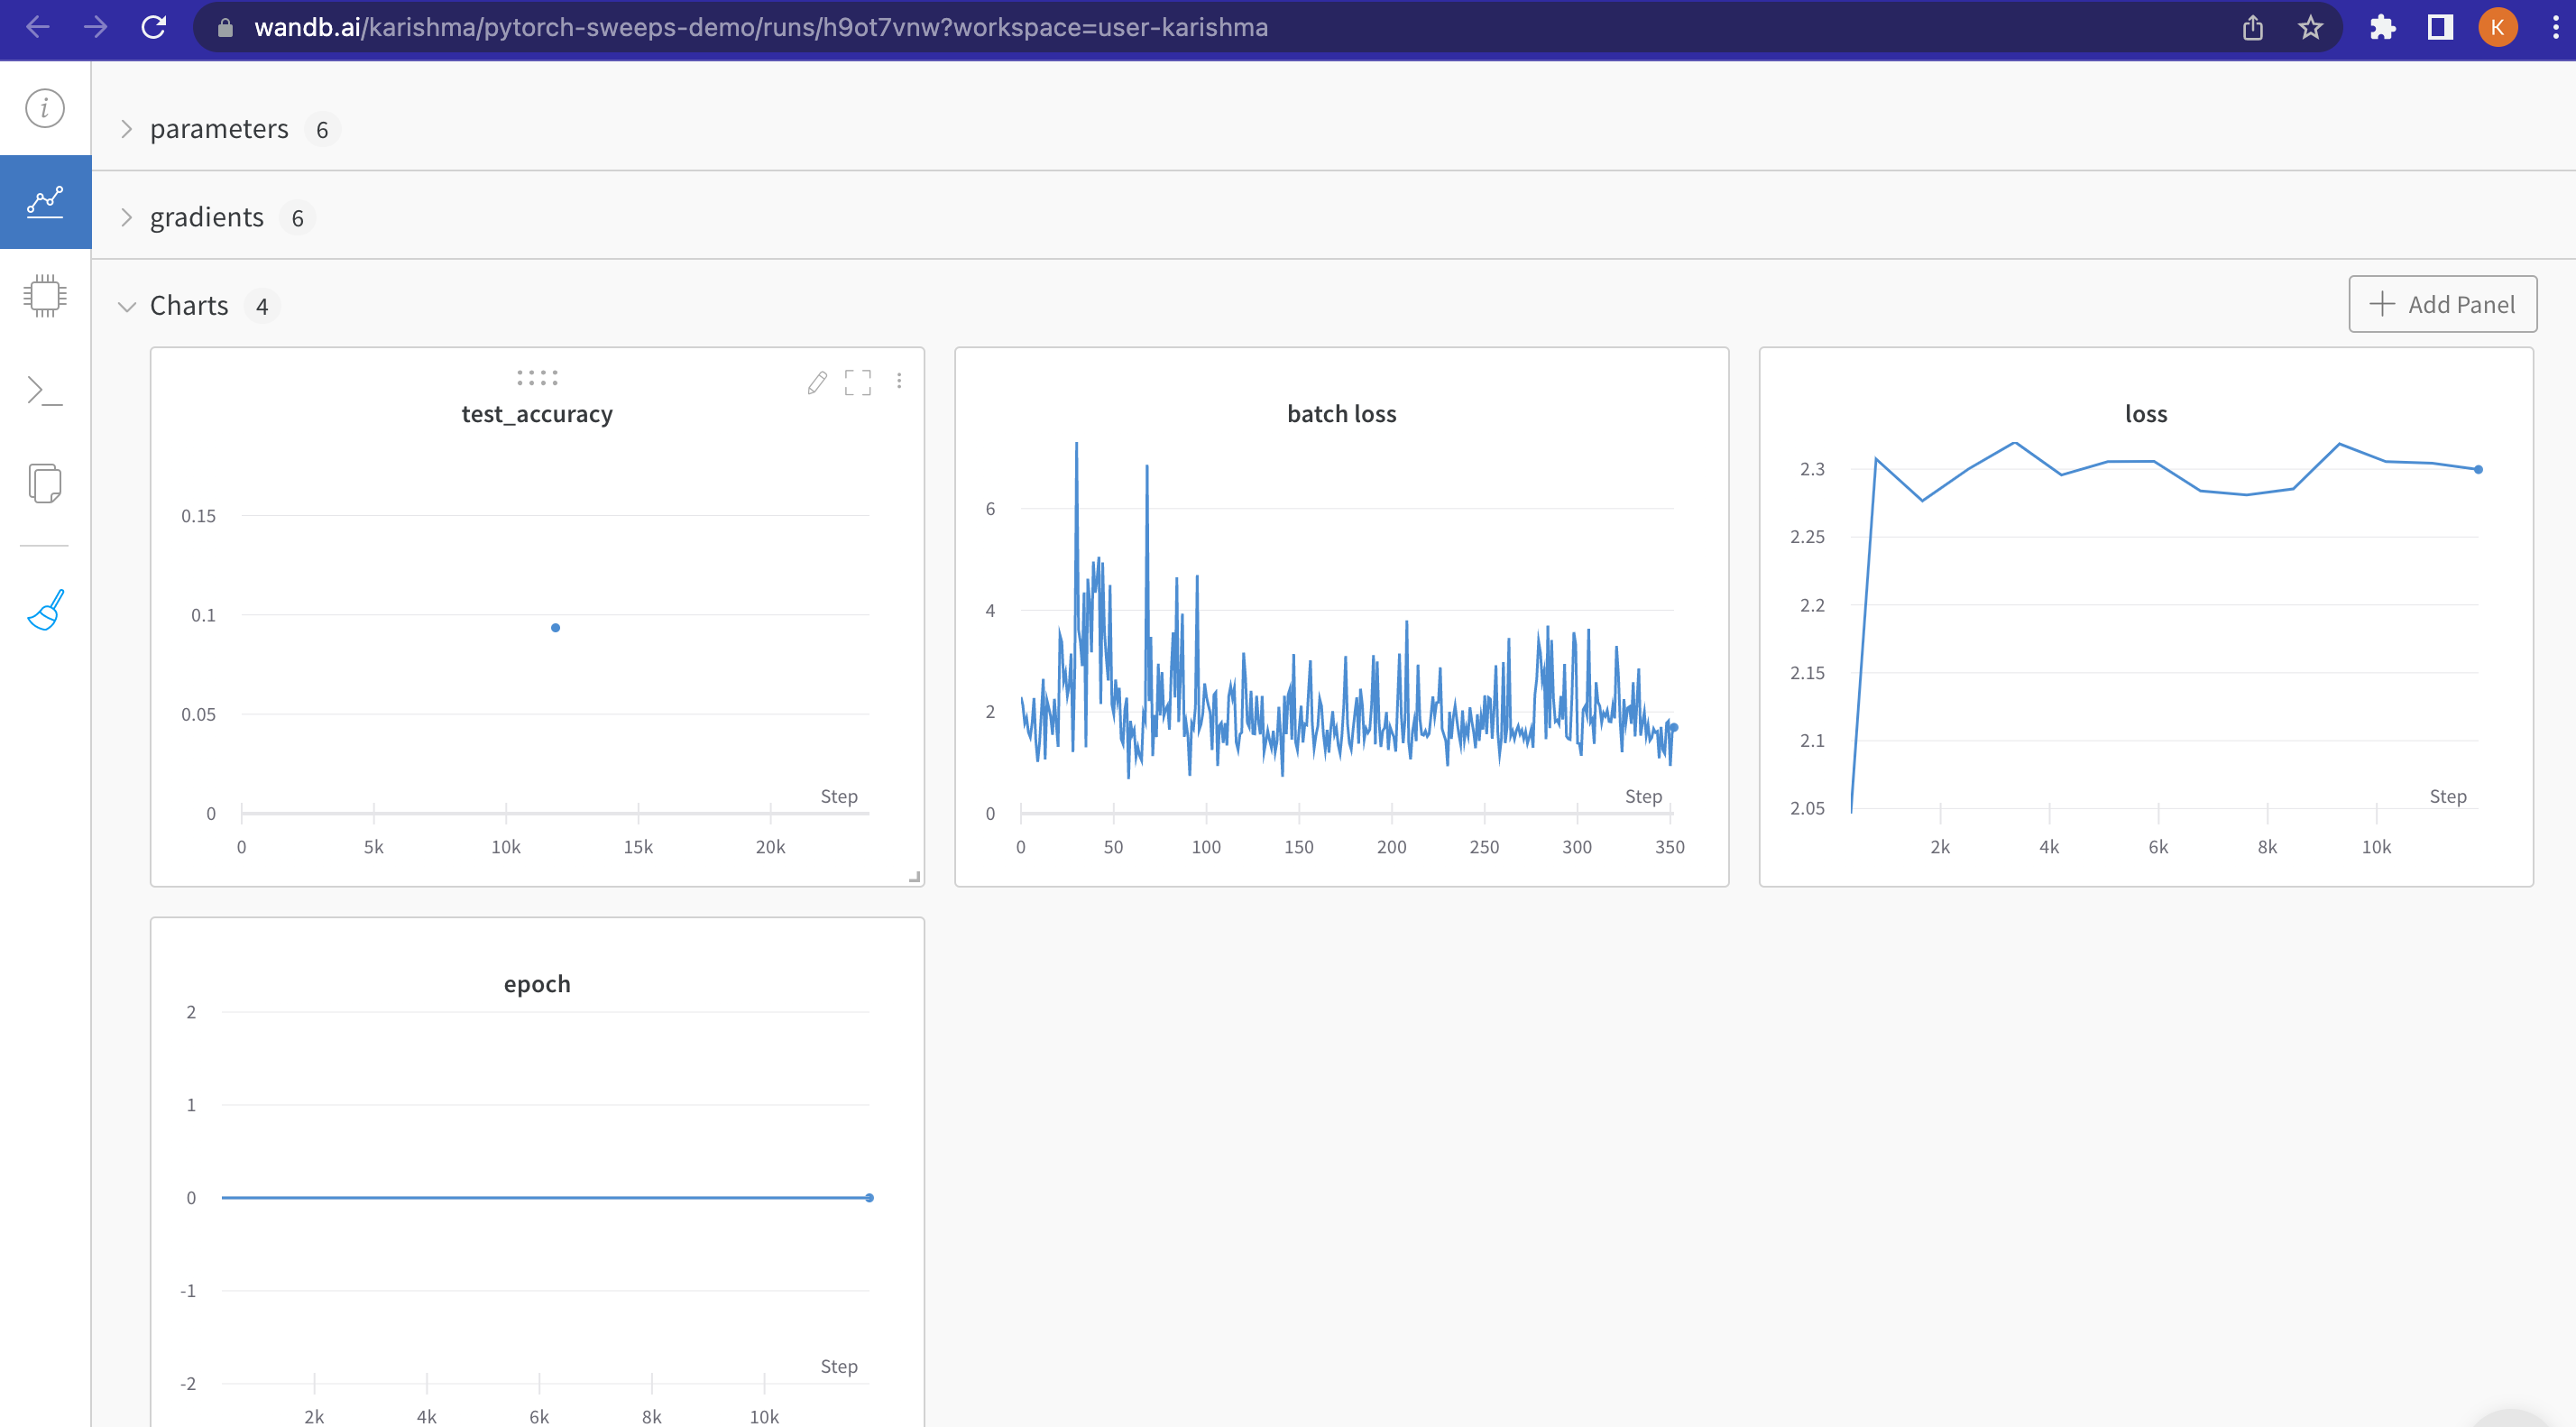